In [2]:
import pysal

/home/hcchen/anaconda3/envs/emb-geometry/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [3]:
import os
import operator
import pandas as pd
import pickle
import random
import sklearn
import powerlaw
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors
from scipy.io import loadmat, savemat
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

sns.set()

In [4]:
from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags

In [5]:
%matplotlib inline

In [6]:
%load_ext autoreload
%autoreload 2

# Spatial Correlation on Toy Data

The Gamma Index of spatial autocorrelation consists of the application of the principle behind a general cross-product statistic to measuring spatial autocorrelation. The idea is to assess whether two similarity matrices for n objects, i.e., n by n matrices A and B measure the same type of similarity. This is reflected in a so-called Gamma Index $\Gamma = \sum_i \sum_j a_{ij} \cdot b_{ij}$.
In other words, the statistic consists of the sum over all cross-products of matching elements (i,j) in the two matrices.

The application of this principle to spatial autocorrelation consists of turning the first similarity matrix into a measure of attribute similarity and the second matrix into a measure of locational similarity. Naturally, the second matrix is the a spatial weight matrix. The first matrix can be any reasonable measure of attribute similarity or dissimilarity, such as a cross-product, squared difference or absolute difference.

Formally, then, the Gamma index is:

$$\Gamma = \sum_i \sum_j a_{ij} \cdot w_{ij}$$

where the $w_{ij}$ are the elements of the weights matrix and $a_{ij}$ are corresponding measures of attribute similarity.

Inference for this statistic is based on a permutation approach in which the values are shuffled around among the locations and the statistic is recomputed each time. This creates a reference distribution for the statistic under the null hypothesis of spatial randomness. The observed statistic is then compared to this reference distribution and a pseudo-significance computed as

$$p = (m + 1) / (n + 1)$$

where m is the number of values from the reference distribution that are equal to or greater than the observed join count and n is the number of permutations.

Many spatial autocorrelation test statistics can be shown to be special cases of the Gamma index. In most instances, the Gamma index is an unstandardized version of the commonly used statistics. As such, the Gamma index is scale dependent, since no normalization is carried out (such as deviations from the mean or rescaling by the variance). Also, since the sum is over all the elements, the value of a Gamma statistic will grow with the sample size, everything else being the same.

In [93]:
w = pysal.lat2W(4,4)
y = np.ones(16)
y[0:8] = 0

In [105]:
w.full()

(array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

Use cross product for attribute similarity:

In [95]:
g = pysal.Gamma(y, w)
g.g

20.0

Positive value indicates positive correlation.

In [97]:
"%.3f" % g.g_z

'3.253'

In [98]:
g.p_sim_g

0.002

In [99]:
g.min_g

2.0

In [100]:
g.max_g

20.0

In [101]:
g.mean_g

11.381381381381381

Use squared difference instead for attribute similarity:

In [106]:
np.random.seed(12345)

In [107]:
g1 = pysal.Gamma(y,w,operation='s')

In [108]:
"%.3f"%g1.g_z

'-3.706'

In [109]:
g1.p_sim_g

0.001

In [110]:
g1.min_g

14.0

In [111]:
g1.max_g

48.0

In [112]:
g1.mean_g

25.623623623623622

## Moran's I

Moran’s I measures the global spatial autocorrelation in an attribute $y$ measured over $n$ spatial units and is given as:
$$I=\frac{N}{W} \frac{\sum_{i} \sum_{j} w_{i j}\left(y_{i}-\overline{y}\right)\left(y_{j}-\overline{y}\right)}{\sum_{i}\left(y_{i}-\overline{y}\right)^{2}}$$
where $w_{ij}$ are the spatial weights and $W$ is the sum of all $w_{ij}$.

If we still consider a board with black and white squares, then when the white and black squares are perfectly dispersed, Moran's I would be −1. If the white squares were stacked to one half of the board and the black squares to the other, Moran's I would be close to +1. A random arrangement of square colors would give Moran's I a value that is close to 0.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Checkerboard_pattern.svg/440px-Checkerboard_pattern.svg.png" alt="Drawing" style="width: 200px;"/>

Now let's verify this:

In [154]:
w = pysal.lat2W(5,5)
y = np.asarray([1.0, 0.0] * 12 + [1.0])

In [155]:
mi = pysal.Moran(y, w, two_tailed=True)

In [156]:
"%.3f" % mi.I

'-1.000'

In [157]:
w = pysal.lat2W(4,4)
y = np.ones(16)
y[0:8] = 0

In [158]:
mi1 = pysal.Moran(y, w, two_tailed=True)

In [159]:
mi1.I

0.7083333333333333

## Geary's C

Geary's C is defined as
$$C=\frac{(N-1) \sum_{i} \sum_{j} w_{i j}\left(y_{i}-y_{j}\right)^{2}}{2 W \sum_{i}\left(y_{i}-\overline{y}\right)^{2}}$$

where $w_{ij}$ are the spatial weights and $W$ is the sum of all $w_{ij}$.

The value of Geary's C lies between 0 and some unspecified value greater than 1. Values significantly lower than 1 demonstrate increasing positive spatial autocorrelation, whilst values significantly higher than 1 illustrate increasing negative spatial autocorrelation.

Geary's C is inversely related to Moran's I, but it is not identical. Moran's I is a measure of global spatial autocorrelation, while Geary's C is more sensitive to local spatial autocorrelation.

# Run DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input /home/hcchen/emb-geometry/ba-n=10000-m=20.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 20 --output /home/hcchen/emb-geometry/ba-n=10000-m=20.mat &

# Construct a Preferential Attachment Graph

## Small One

In [180]:
n = 2000
m = 20
G = nx.barabasi_albert_graph(n, m, seed=42)
A = nx.to_scipy_sparse_matrix(G)

In [ ]:
savemat('ba-n=%d-m=%d.mat' % (n, m), {'network': nx.to_scipy_sparse_matrix(G)})

In [182]:
d = np.asarray([int(d) for node, d in G.degree])

('alpha= ', 1.2384415556528208, '  sigma= ', 0.005331715271005065)


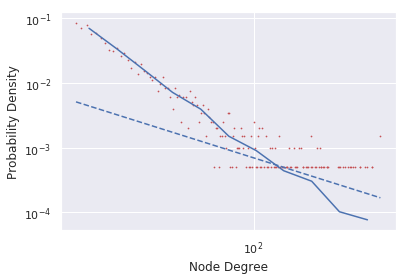

In [161]:
import powerlaw
fit = powerlaw.Fit(d, xmin=1, discrete=True)
x, y = powerlaw.pdf(d, linear_bins=True)
ind = y>0
y = y[ind]
x = x[:-1]
x = x[ind]

plt.scatter(x, y, color='r', s=.5)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')
plt.xlabel('Node Degree')
plt.ylabel('Probability Density')
# plt.savefig('text8-wordfreq.pdf')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

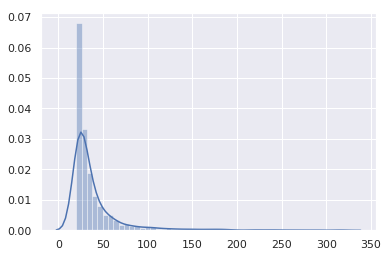

In [166]:
sns.distplot(d)

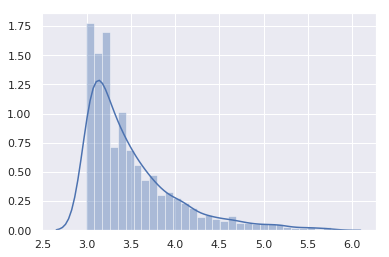

In [165]:
sns.distplot(np.log(d))

In [ ]:
python3 src/randne.py --input /home/hcchen/emb-geometry/ba-n=2000-m=20.mat \
--output /home/hcchen/emb-geometry/rp-ba-n=2000-m=20.mat -q 3 -d 128 --weights 1 0.01 0.001

In [176]:
rp_emb = loadmat('/home/hcchen/emb-geometry/rp-ba-n=2000-m=20.mat')['emb']
%time rp_emb_w = pysal.weights.util.full2W(cosine_similarity(rp_emb, rp_emb))

CPU times: user 2 s, sys: 2.79 s, total: 4.79 s
Wall time: 1.32 s


In [ ]:
mir.EI_sim

In [16]:
%time mi = pysal.Moran(d, rp_emb_w, two_tailed=False)

CPU times: user 9.77 s, sys: 242 ms, total: 10 s
Wall time: 10 s


In [20]:
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

I: 0.000134, EI: -0.000500, p: 0.00000


Use the log of frequency:

In [21]:
%time mi = pysal.Moran(map(math.log, d), rp_emb_w, two_tailed=False)

CPU times: user 8.7 s, sys: 265 ms, total: 8.97 s
Wall time: 8.96 s


In [22]:
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

I: 0.000243, EI: -0.000500, p: 0.00000


Use log frequency + Euclidean distance in emb space:

In [177]:
%time rp_emb_l2_w = pysal.weights.util.full2W(euclidean_distances(rp_emb, rp_emb))

CPU times: user 2.13 s, sys: 3.37 s, total: 5.5 s
Wall time: 1.12 s


In [183]:
%time mi = pysal.Moran(map(math.log, d), rp_emb_l2_w, two_tailed=False)

CPU times: user 8.36 s, sys: 216 ms, total: 8.58 s
Wall time: 8.58 s


In [184]:
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

I: -0.165348, EI: -0.000500, p: 0.00000


In [ ]:
nohup time deepwalk --format mat --input /home/hcchen/emb-geometry/ba-n=2000-m=20.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 20 --output /home/hcchen/emb-geometry/ba-n=2000-m=20.emb &

In [66]:
dw_model = KeyedVectors.load_word2vec_format('/home/hcchen/emb-geometry/ba-n=2000-m=20.emb')
N = len(dw_model.vocab)
dw_emb = np.asarray([dw_model[str(node)] for node in range(N)])

In [68]:
%time dw_emb_w = pysal.weights.util.full2W(cosine_similarity(dw_emb, dw_emb))

CPU times: user 1.97 s, sys: 1.19 s, total: 3.16 s
Wall time: 1.89 s


In [69]:
%time mi = pysal.Moran(d, dw_emb_w, two_tailed=False)

CPU times: user 33.6 s, sys: 641 ms, total: 34.2 s
Wall time: 34.7 s


In [70]:
mi.I

0.002874369182722769

In [71]:
mi.EI

-0.0005002501250625312

In [72]:
mi.p_norm

1.82609901903108e-05

## Large One

In [167]:
n = 10000
m = 20
G = nx.barabasi_albert_graph(n, m, seed=42)

In [168]:
G.number_of_nodes()

10000

In [169]:
G.number_of_edges()

199600

In [79]:
A = nx.to_scipy_sparse_matrix(G)

In [56]:
savemat('ba-n=%d-m=%d.mat' % (n, m), {'network': nx.to_scipy_sparse_matrix(G)})

Save as a .mat file:

In [170]:
d = np.asarray([int(d) for node, d in G.degree])

('alpha= ', 1.2388343643055604, '  sigma= ', 0.002388343643055604)


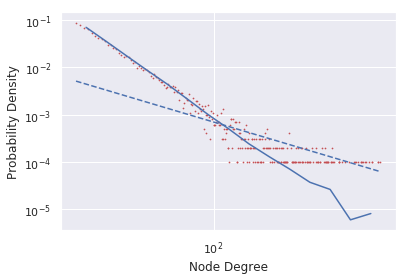

In [16]:
import powerlaw
fit = powerlaw.Fit(d, xmin=1, discrete=True)
x, y = powerlaw.pdf(d, linear_bins=True)
ind = y>0
y = y[ind]
x = x[:-1]
x = x[ind]

plt.scatter(x, y, color='r', s=.5)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')
plt.xlabel('Node Degree')
plt.ylabel('Probability Density')
# plt.savefig('text8-wordfreq.pdf')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

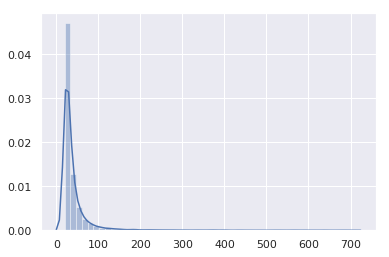

In [171]:
sns.distplot(d)

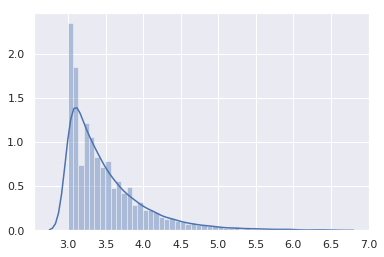

In [172]:
sns.distplot(np.log(d))

## Random Projection on BA Graph

In [ ]:
python3 src/randne.py --input /home/hcchen/emb-geometry/ba-n=10000-m=20.mat \
--output /home/hcchen/emb-geometry/rp-ba-n=10000-m=20.mat -q 3 -d 128 --weights 1 0.01 0.001

Load the embeddings:

In [73]:
rp_emb = loadmat('/home/hcchen/emb-geometry/rp-ba-n=10000-m=20.mat')['emb']

In [74]:
%time rp_emb_w = pysal.weights.util.full2W(cosine_similarity(rp_emb, rp_emb))

CPU times: user 30.8 s, sys: 5.83 s, total: 36.6 s
Wall time: 34.1 s


In [81]:
%time mi = pysal.Moran(d, rp_emb_w, two_tailed=False)

CPU times: user 3min 57s, sys: 10.6 s, total: 4min 8s
Wall time: 4min 8s


In [82]:
mi.I

7.977332197853172e-05

In [83]:
mi.EI

-0.00010001000100010001

In [84]:
"%.5f" % mi.p_norm

'0.00000'

## DeepWalk on BA Graph

We run this command (in shell):

In [ ]:
nohup time deepwalk --format mat --input /home/hcchen/emb-geometry/ba-n=10000-m=20.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 20 --output /home/hcchen/emb-geometry/ba-n=10000-m=20.emb &

Then load the embeddings:

In [86]:
dw_model = KeyedVectors.load_word2vec_format('/home/hcchen/emb-geometry/ba-n=10000-m=20.emb')
N = len(dw_model.vocab)
dw_emb = np.asarray([dw_model[str(node)] for node in range(N)])

In [89]:
%time dw_emb_w = pysal.weights.util.full2W(cosine_similarity(dw_emb, dw_emb))

CPU times: user 38.4 s, sys: 10.2 s, total: 48.6 s
Wall time: 45.3 s


In [90]:
%time mi = pysal.Moran(d, dw_emb_w, two_tailed=False)

CPU times: user 11min 5s, sys: 20.5 s, total: 11min 26s
Wall time: 11min 26s


In [91]:
mi.I

0.0004437254504801698

In [92]:
mi.EI

-0.00010001000100010001

In [93]:
"%.5f" % mi.p_norm

'0.00085'

# Glove

Load embeddings and frequencies:

In [10]:
def load_glove(glove_file):
    print ('Loading Glove Model')
    f = open(glove_file, 'r')
    words, embs = [], []
    for line in f:
        split_line = line.split(' ')
        word = split_line[0]
        words.append(word)
        emb = np.array([float(val) for val in split_line[1:]])
        embs.append(emb)
    print ('Done.', len(words), 'words loaded!')
    return words, np.asarray(embs)

In [11]:
%time words, glove_embs = load_glove('glove.text8.50d.70k.txt')

Loading Glove Model
('Done.', 71291, 'words loaded!')
CPU times: user 1.62 s, sys: 86.6 ms, total: 1.7 s
Wall time: 1.71 s


In [23]:
lat2W_4 = pysal.lat2W(4,4)

In [26]:
lat2W_4.full()

(array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [12]:
freq_map = {}
glove_freq = []
with open('glove.text8.vocab.txt') as fp:
    for line in fp:
        word, freq = line.split(' ')
        glove_freq.append(int(freq.strip()))
        freq_map[word] = int(freq.strip())

Use a frequency filter here:

In [13]:
len([word for word in words if word in freq_map and freq_map[word] >= 100])

11815

In [173]:
N = 11815
glove_embs_N = glove_embs[:N]
glove_freq_N = glove_freq[:N]

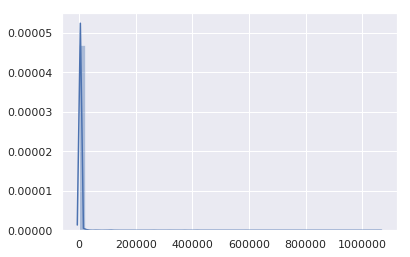

In [174]:
sns.distplot(glove_freq_N)

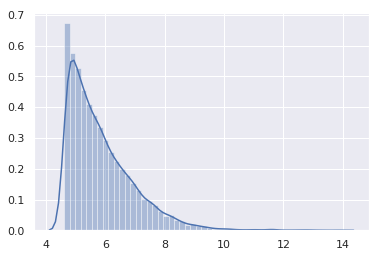

In [175]:
sns.distplot(np.log(glove_freq_N))

In [100]:
%time glove_emb_w = pysal.weights.util.full2W(cosine_similarity(glove_embs_N, glove_embs_N))

CPU times: user 40.6 s, sys: 8.83 s, total: 49.5 s
Wall time: 44.1 s


Compute spatial autocorrelation stats:

In [47]:
%time mi = pysal.Moran(glove_freq_N, glove_emb_w, two_tailed=False)

CPU times: user 6min 16s, sys: 18.8 s, total: 6min 35s
Wall time: 6min 35s


In [48]:
mi.I

0.006873175363268437

In [49]:
mi.EI

-8.464533604198409e-05

In [50]:
"%.5f" % mi.p_norm

'0.37706'

Or use the log of frequency count?

In [101]:
%time mi = pysal.Moran(map(math.log, glove_freq_N), glove_emb_w, two_tailed=False)

CPU times: user 6min 25s, sys: 31.2 s, total: 6min 56s
Wall time: 6min 56s


In [102]:
mi.I

0.5399524593349561

In [103]:
mi.EI

-8.464533604198409e-05

In [104]:
"%.5f" % mi.p_norm

'0.00000'

# Blogcatalog

## DeepWalk

Load the embeddings:

In [74]:
dw_model = KeyedVectors.load_word2vec_format('/home/hcchen/fast-random-projection/result/blogcatalog-dw.emb')
N = len(dw_model.vocab)
dw_emb = np.asarray([dw_model[str(node)] for node in range(N)])

In [41]:
%time dw_emb_w = pysal.weights.util.full2W(cosine_similarity(dw_emb, dw_emb))

CPU times: user 27.3 s, sys: 7.57 s, total: 34.8 s
Wall time: 29.9 s


In [75]:
blog = loadmat('/home/hcchen/fast-random-projection/example_graphs/blogcatalog.mat')
blog_A = blog['network']

In [76]:
blog_A

<10312x10312 sparse matrix of type '<type 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [77]:
d = np.squeeze(np.asarray(blog_A.sum(axis=1)))

('alpha= ', 1.2652090861198588, '  sigma= ', 0.0026116618603230194)


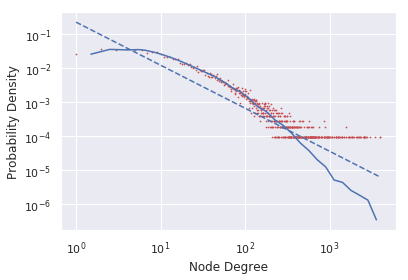

In [78]:
import powerlaw
fit = powerlaw.Fit(d, xmin=1, discrete=True)
x, y = powerlaw.pdf(d, linear_bins=True)
ind = y>0
y = y[ind]
x = x[:-1]
x = x[ind]

plt.scatter(x, y, color='r', s=.5)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')
plt.xlabel('Node Degree')
plt.ylabel('Probability Density')
# plt.savefig('text8-wordfreq.pdf')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

In [67]:
%time mi = pysal.Moran(d, dw_emb_w, two_tailed=False)

CPU times: user 9min 57s, sys: 23.2 s, total: 10min 20s
Wall time: 10min 15s


In [68]:
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

I: 0.007498, EI: -0.000097, p: 0.00000


In [69]:
%time mi = pysal.Moran(map(math.log, d), dw_emb_w, two_tailed=False)

CPU times: user 3min 54s, sys: 14.1 s, total: 4min 8s
Wall time: 4min 8s


In [70]:
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

I: 0.026749, EI: -0.000097, p: 0.00000


## Random Projection

In [71]:
rp_emb = loadmat('/home/hcchen/fast-random-projection/result/blog-randne-emb.mat')['emb']

In [79]:
%time rp_emb_w = pysal.weights.util.full2W(cosine_similarity(rp_emb, rp_emb))

CPU times: user 30.9 s, sys: 8.23 s, total: 39.2 s
Wall time: 29.6 s


In [83]:
%time mi = pysal.Moran(d, rp_emb_w, two_tailed=False)
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

CPU times: user 3min 49s, sys: 15.8 s, total: 4min 5s
Wall time: 4min 5s
I: 0.001266, EI: -0.000097, p: 0.00000


In [82]:
%time mi = pysal.Moran(map(math.log, d), rp_emb_w, two_tailed=False)
print ('I: %f, EI: %f, p: %.5f' % (mi.I, mi.EI, mi.p_norm) )

CPU times: user 3min 56s, sys: 14.9 s, total: 4min 11s
Wall time: 4min 11s
I: 0.004998, EI: -0.000097, p: 0.00000


# Sergiy

In [ ]:
pd.read_csv